In [186]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

from google.colab import drive
drive.mount('/content/drive')

# df = pd.read_csv("csgo_round_snapshots.csv")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/csgo_round_snapshots.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
PcaNumberOfCompontents = 40

In [188]:
df

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,de_train,True,200.0,242.0,195.0,359.0,100.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122406,174.93,11.0,15.0,de_train,False,500.0,500.0,95.0,175.0,11500.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122407,114.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,T
122408,94.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,T


In [189]:
df.keys()

Index(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',
       'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
       'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',
       'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
       'ct_weapon_negev', 't_weapon_negev',

de_inferno     23811
de_dust2       22144
de_nuke        19025
de_mirage      18576
de_overpass    14081
de_train       13491
de_vertigo     11137
de_cache         145
Name: map, dtype: int64


Text(0, 0.5, 'Count')

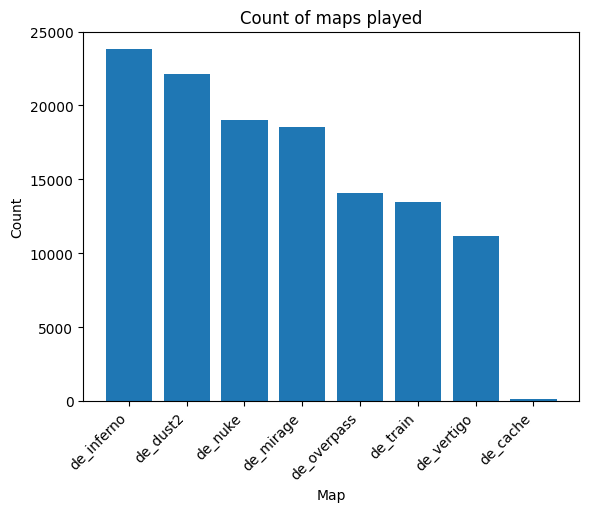

In [190]:

counts = df['map'].value_counts()
print(counts)
total = counts.sum()
percentages = counts / total * 100

plt.bar(counts.index, counts.values)

plt.xticks(rotation=45, ha='right')
plt.title('Count of maps played')
plt.xlabel('Map')
plt.ylabel('Count')

In [191]:
df.groupby('map')['map'].count()

map
de_cache         145
de_dust2       22144
de_inferno     23811
de_mirage      18576
de_nuke        19025
de_overpass    14081
de_train       13491
de_vertigo     11137
Name: map, dtype: int64

In [192]:
df.groupby('map')['map'].count().values

array([  145, 22144, 23811, 18576, 19025, 14081, 13491, 11137])

In [193]:
df.groupby('map')['map'].count().values.reshape(-1, 1)

array([[  145],
       [22144],
       [23811],
       [18576],
       [19025],
       [14081],
       [13491],
       [11137]])

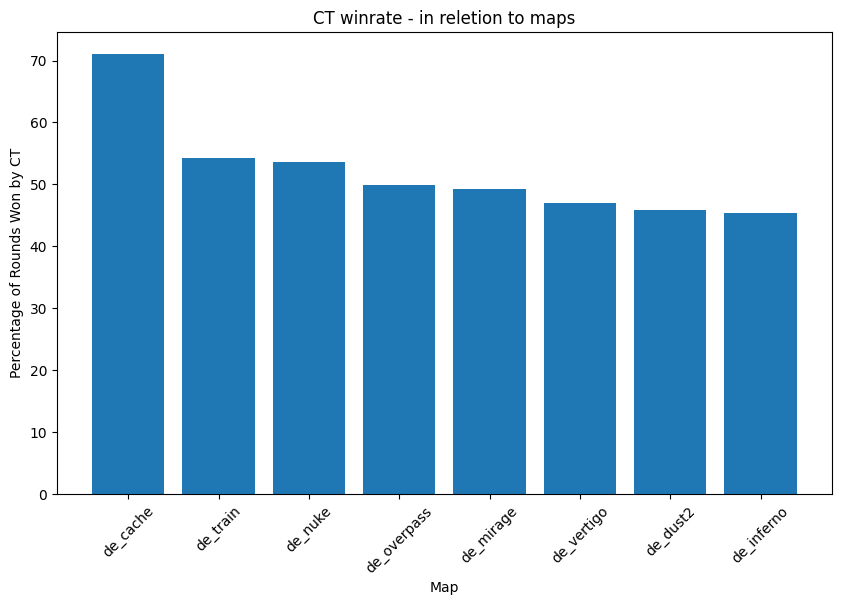

In [194]:
map_win_pct = df.groupby(['map', 'round_winner'])['round_winner'].count().unstack() / df.groupby('map')['map'].count().values.reshape(-1, 1)
ct_win_pct = map_win_pct['CT']*100

ct_win_pct = ct_win_pct.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(ct_win_pct.index, ct_win_pct)
plt.xticks(rotation=45)

plt.xlabel('Map')
plt.ylabel('Percentage of Rounds Won by CT')
plt.title('CT winrate - in reletion to maps')
plt.show()

## elements to convert to numbers:
|----------|--------------|--------------|
| map      | bomb_planted | round_winner |
|----------|--------------|--------------|
| de_dust2 | False        | CT           |
|----------|--------------|--------------|

In [195]:
# changing strings to nubmers

bool_to_numbers = {
    'False': 0,
    'True': 1
}

team_to_number = {
    'CT': 0,
    'T': 1
}

map_to_number = {
    'de_cache': 1,
    'de_dust2': 2,
    'de_inferno': 3,
    'de_mirage': 4,
    'de_nuke': 5,
    'de_overpass': 6,
    'de_train': 7,
    'de_vertigo': 8
}

df['map'] = df['map'].replace(map_to_number)
df['bomb_planted'] = df['bomb_planted'].replace(bool_to_numbers)
df['round_winner'] = df['round_winner'].replace(team_to_number)

attrToIndex = {attr: index for index, attr in enumerate(df.keys())}
print(attrToIndex)

{'time_left': 0, 'ct_score': 1, 't_score': 2, 'map': 3, 'bomb_planted': 4, 'ct_health': 5, 't_health': 6, 'ct_armor': 7, 't_armor': 8, 'ct_money': 9, 't_money': 10, 'ct_helmets': 11, 't_helmets': 12, 'ct_defuse_kits': 13, 'ct_players_alive': 14, 't_players_alive': 15, 'ct_weapon_ak47': 16, 't_weapon_ak47': 17, 'ct_weapon_aug': 18, 't_weapon_aug': 19, 'ct_weapon_awp': 20, 't_weapon_awp': 21, 'ct_weapon_bizon': 22, 't_weapon_bizon': 23, 'ct_weapon_cz75auto': 24, 't_weapon_cz75auto': 25, 'ct_weapon_elite': 26, 't_weapon_elite': 27, 'ct_weapon_famas': 28, 't_weapon_famas': 29, 'ct_weapon_g3sg1': 30, 't_weapon_g3sg1': 31, 'ct_weapon_galilar': 32, 't_weapon_galilar': 33, 'ct_weapon_glock': 34, 't_weapon_glock': 35, 'ct_weapon_m249': 36, 't_weapon_m249': 37, 'ct_weapon_m4a1s': 38, 't_weapon_m4a1s': 39, 'ct_weapon_m4a4': 40, 't_weapon_m4a4': 41, 'ct_weapon_mac10': 42, 't_weapon_mac10': 43, 'ct_weapon_mag7': 44, 't_weapon_mag7': 45, 'ct_weapon_mp5sd': 46, 't_weapon_mp5sd': 47, 'ct_weapon_mp7': 

In [196]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_features, columns=df.columns)



{'whiskers': [<matplotlib.lines.Line2D at 0x7fd751bfe3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd751bfeb20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd751be6b80>,
 'medians': [<matplotlib.lines.Line2D at 0x7fd751bfee80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd751bfe5b0>,
 'means': []}

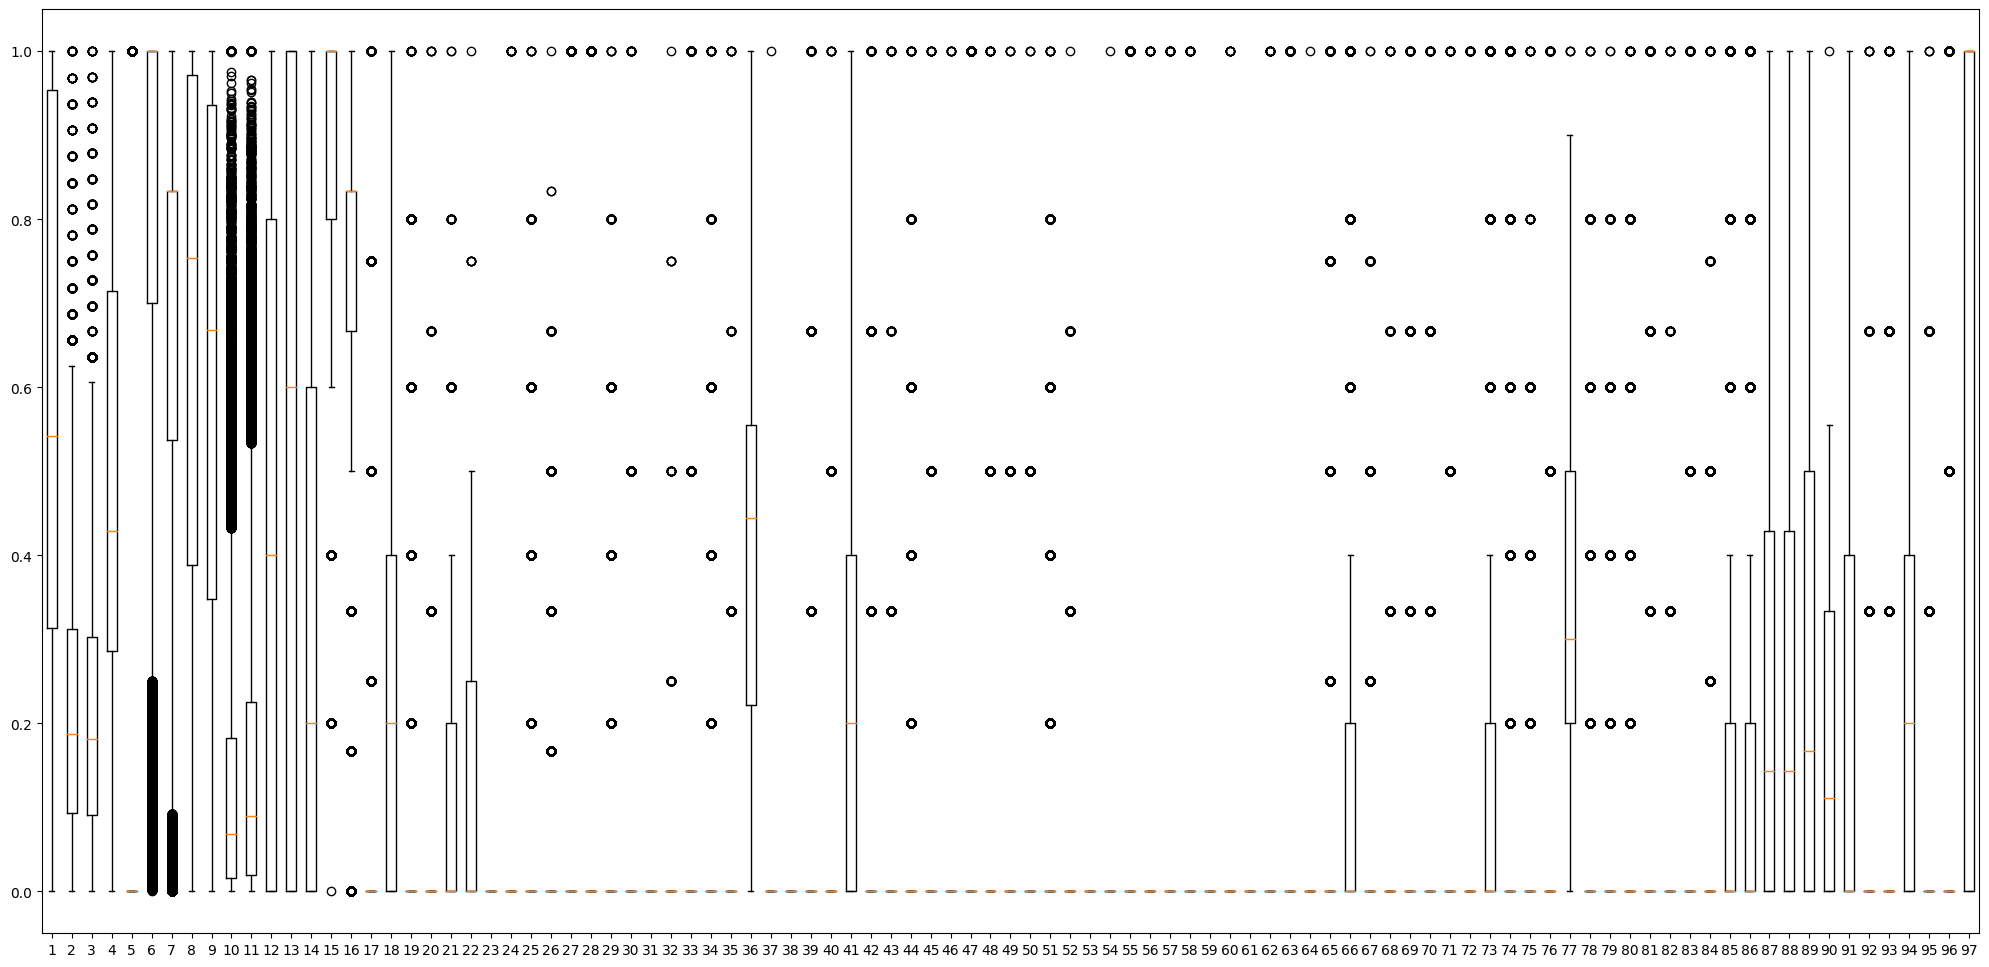

In [197]:
fig, ax = plt.subplots(figsize=(25,12))

ax.boxplot(scaled_df.to_numpy())

In [198]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto')
IF.fit(scaled_df)

IsolationForest()

In [199]:
if_results = IF.predict(scaled_df)  
scaled_df_without_outliers = scaled_df[if_results==1]
outliers = scaled_df[if_results==-1]

class_results = scaled_df_without_outliers['round_winner']
scaled_df_without_outliers = scaled_df_without_outliers.drop('round_winner',axis=1)

In [200]:
print(scaled_df.shape)
print(scaled_df_without_outliers.shape)
print(class_results.shape)
print(max(scaled_df_without_outliers.to_numpy()[:,0]))

(122410, 97)
(121865, 96)
(121865,)
0.9999999999999999


In [201]:
# check missing data
missing_data = df.isnull()
print(missing_data.sum().sum())

0


In [202]:
counts = df['map'].value_counts()
print(counts)

counts = scaled_df['map'].value_counts()
print(counts)

3    23811
2    22144
5    19025
4    18576
6    14081
7    13491
8    11137
1      145
Name: map, dtype: int64
0.285714    23811
0.142857    22144
0.571429    19025
0.428571    18576
0.714286    14081
0.857143    13491
1.000000    11137
0.000000      145
Name: map, dtype: int64


In [203]:
from sklearn.decomposition import PCA

pca = PCA(n_components=PcaNumberOfCompontents)
pca.fit(scaled_df_without_outliers)

scaled_df_without_outliers_pca = pca.transform(scaled_df_without_outliers)
print(scaled_df_without_outliers_pca.shape) 
print(pca.explained_variance_ratio_)

(121865, 40)
[0.29220279 0.157643   0.12798351 0.03576054 0.03386077 0.0319824
 0.02734218 0.02561873 0.02224197 0.01849206 0.01701165 0.01363795
 0.01300032 0.01153566 0.00959771 0.00937622 0.00881511 0.00818838
 0.00774628 0.00724442 0.00686977 0.00680299 0.00603369 0.00566452
 0.00559339 0.00545124 0.00510807 0.00496481 0.00475528 0.004194
 0.00381934 0.00340904 0.00336631 0.00324318 0.00322645 0.00317302
 0.0028889  0.00275897 0.00263291 0.00236287]


# Uczenie

In [204]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

knn = KNeighborsClassifier(n_neighbors=40, weights='distance', algorithm='ball_tree')

x_scaled_train, x_scaled_test, y_scaled_train, y_scaled_test = train_test_split(scaled_df_without_outliers_pca, class_results, test_size=0.15, shuffle=True, random_state=None, stratify=class_results)

In [205]:
knn.fit(x_scaled_train,y_scaled_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=40, weights='distance')

In [206]:
knn.score(x_scaled_test,y_scaled_test)

0.7997264770240701